In [18]:
#Conectar ao Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


<p>Base de dados : 
<a href="https://drive.google.com/drive/folders/1jhMG6vnsKqDm5uILBMLezU2Ll5ljWOZy?usp=share_link">Click Aqui</a></p>

In [3]:
# importar Bibliotecas
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf 
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [7]:
# Datasets
import pathlib
data_dir = "/content/drive/MyDrive/african_attires"
data_dir_train = "/content/drive/MyDrive/african_attires/Train"
data_dir_validation = "/content/drive/MyDrive/african_attires/Validation"

In [8]:
import cv2 

# Limpesa de dados
def check_images(s_dir, ext_list):
    bad_images=[] # armaxena as imgens com errp
    bad_ext=[]  # armazena a extensão de imagens com erro
    s_list= os.listdir(s_dir) # carrega a localização das imagens
    for klass in s_list: # vai para o diretório da imagem
        klass_path=os.path.join (s_dir, klass)  
        print ('processing class directory ', klass)
        if os.path.isdir(klass_path):
            file_list=os.listdir(klass_path)
            for f in file_list:               
                f_path=os.path.join (klass_path,f)
                index=f.rfind('.')
                ext=f[index+1:].lower()
                if ext not in ext_list:  # looping para imagens com erro
                    print('file ', f_path, ' has an invalid extension ', ext)
                    bad_ext.append(f_path)
                if os.path.isfile(f_path):
                    try:
                        img = cv2.imread(f_path)
                        shape = img.shape
                        image_contents = tf.io.read_file(f_path)
                        image = tf.image.decode_jpeg(image_contents, channels=3) # abre a imagem e checa se existe ou não erro nela 
                    except Exception as e:
                        print('file ', f_path, ' is not a valid image file')
                        print(e)
                        bad_images.append(f_path)
                else:
                    print('*** fatal error, you a sub directory ', f, ' in class directory ', klass)
        else:
            print ('*** WARNING*** you have files in ', s_dir, ' it should only contain sub directories')
    return bad_images, bad_ext

In [9]:
#Chamando a função auxiliar.
source_dir = data_dir_train
good_exts=["bmp", "gif", "jpeg", "png","jpg"] # list of acceptable extensions
bad_file_list, bad_ext_list=check_images(source_dir, good_exts)
if len(bad_file_list) !=0:
    print('improper image files are listed below')

print(bad_file_list)
print(bad_ext_list)

processing class directory  Idoma
processing class directory  Zulu
processing class directory  Tswana-Shweshwe
processing class directory  Tiv
processing class directory  Igala
processing class directory  Idgo
processing class directory  Adire
processing class directory  Xhosa-South Africa
[]
[]


In [10]:
img_height,img_width=180,180 #Definindo as dimensões da imagem.
batch_size=32

In [11]:
#para os dados de treino
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  #validation_split=0.2,
  #subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 9784 files belonging to 8 classes.


In [12]:
#dados de validação
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_validation,
  #validation_split=0.2,
  #subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2579 files belonging to 8 classes.


In [13]:
class_names = train_ds.class_names
print(class_names)

['Adire', 'Idgo', 'Idoma', 'Igala', 'Tiv', 'Tswana-Shweshwe', 'Xhosa-South Africa', 'Zulu']


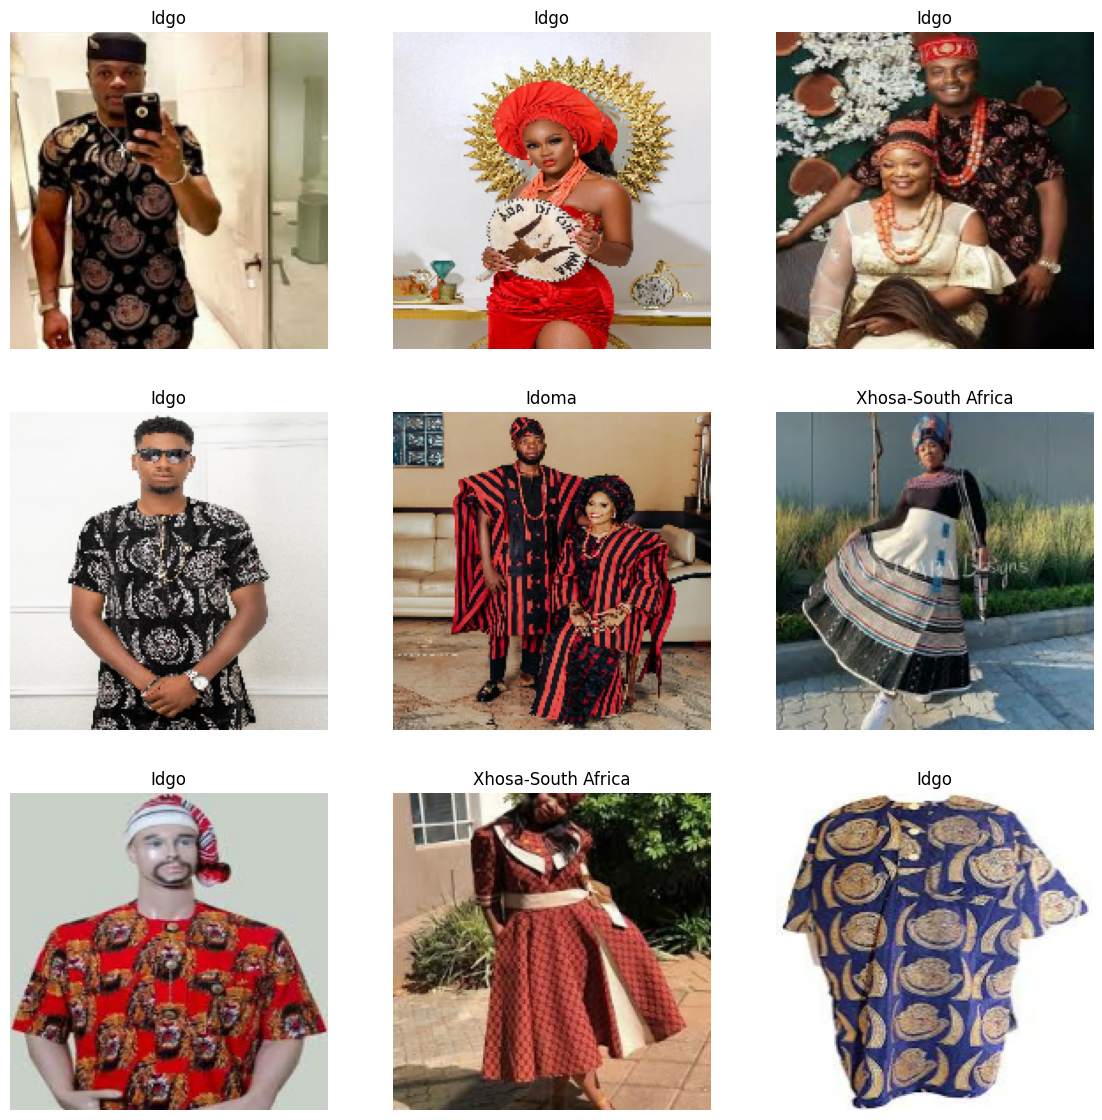

In [14]:
import matplotlib.pyplot as plt

# Percorrendo o conjunto de treinamento para imagens de exemplo.
plt.figure(figsize=(14, 14))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [15]:
num_classes = 8 # O número de classes é igual ao número de diretórios de imagens

# Definir um modelo sequencial com 3 camadas
model = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes,activation='softmax')
])

In [16]:
#Parametros para treinamento
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])


In [17]:
epochs=10 #Definindo o número de passes no modelo.
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/backend.py:5612: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


306/306 [==============================] - 812s 3s/step - loss: 1.3417 - accuracy: 0.5127 - val_loss: 2.6526 - val_accuracy: 0.3133
Epoch 2/10
306/306 [==============================] - 461s 2s/step - loss: 0.8676 - accuracy: 0.6934 - val_loss: 3.4907 - val_accuracy: 0.3331
Epoch 3/10
306/306 [==============================] - 464s 2s/step - loss: 0.5630 - accuracy: 0.8095 - val_loss: 3.9324 - val_accuracy: 0.4033
Epoch 4/10
306/306 [==============================] - 460s 1s/step - loss: 0.3321 - accuracy: 0.8917 - val_loss: 4.8904 - val_accuracy: 0.4195
Epoch 5/10
306/306 [==============================] - 486s 2s/step - loss: 0.1915 - accuracy: 0.9444 - val_loss: 5.1831 - val_accuracy: 0.3784
Epoch 6/10
306/306 [==============================] - 465s 2s/step - loss: 0.1337 - accuracy: 0.9613 - val_loss: 6.2111 - val_accuracy: 0.3994
Epoch 7/10
306/306 [==============================] - 468s 2s/step - loss: 0.1085 - accuracy: 0.9713 - val_loss: 7.4832 - val_accuracy: 0.4149
Epoch 8/10